In [1]:
# from https://www.kaggle.com/code/palakpaneer/baseline-mlp-pytorch

In [93]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [94]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import math
# Import necessary modules
from autogluon.tabular import TabularDataset, TabularPredictor
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from itertools import combinations

from sklearn.preprocessing import TargetEncoder

import lightgbm as lgb
import numpy as np

### 1.data

In [96]:
df_train = pd.read_csv("../data/playground-series-s5e4/train.csv", index_col="id")
df_test = pd.read_csv('../data/playground-series-s5e4/test.csv', index_col="id")

submit_df = pd.read_csv('../data/playground-series-s5e4/sample_submission.csv', index_col="id")
df_train.head()

,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
id,,,,,,,,,,,
0,Mystery Matters,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,31.41998
1,Joke Junction,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241
2,Study Sessions,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531
3,Digital Digest,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824
4,Mind & Body,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031


### 2.Preprocessing

In [97]:
# 对于nan进行0替换
df_train.fillna(0, inplace=True)
df_test.fillna(0, inplace=True)
df_train.head()

,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
id,,,,,,,,,,,
0,Mystery Matters,Episode 98,0.00,True Crime,74.81,Thursday,Night,0.00,0.0,Positive,31.41998
1,Joke Junction,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241
2,Study Sessions,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531
3,Digital Digest,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824
4,Mind & Body,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031


In [98]:

def feature_eng(df):
    podc_dict = {
        'Mystery Matters': 0,
        'Joke Junction': 1,
        'Study Sessions': 2,
        'Digital Digest': 3,
        'Mind & Body': 4,
        'Fitness First': 5,
        'Criminal Minds': 6,
        'News Roundup': 7,
        'Daily Digest': 8,
        'Music Matters': 9,
        'Sports Central': 10,
        'Melody Mix': 11,
        'Game Day': 12,
        'Gadget Geek': 13,
        'Global News': 14,
        'Tech Talks': 15,
        'Sport Spot': 16,
        'Funny Folks': 17,
        'Sports Weekly': 18,
        'Business Briefs': 19,
        'Tech Trends': 20,
        'Innovators': 21,
        'Health Hour': 22,
        'Comedy Corner': 23,
        'Sound Waves': 24,
        'Brain Boost': 25,
        "Athlete's Arena": 26,
        'Wellness Wave': 27,
        'Style Guide': 28,
        'World Watch': 29,
        'Humor Hub': 30,
        'Money Matters': 31,
        'Healthy Living': 32,
        'Home & Living': 33,
        'Educational Nuggets': 34,
        'Market Masters': 35,
        'Learning Lab': 36,
        'Lifestyle Lounge': 37,
        'Crime Chronicles': 38,
        'Detective Diaries': 39,
        'Life Lessons': 40,
        'Current Affairs': 41,
        'Finance Focus': 42,
        'Laugh Line': 43,
        'True Crime Stories': 44,
        'Business Insights': 45,
        'Fashion Forward': 46,
        'Tune Time': 47
    }
    genr_dict = {'True Crime': 0, 'Comedy': 1, 'Education': 2, 'Technology': 3, 'Health': 4, 'News': 5, 'Music': 6, 'Sports': 7, 'Business': 8, 'Lifestyle': 9}
    week_dict = {'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3, 'Friday': 4, 'Saturday': 5, 'Sunday': 6}
    time_dict = {'Morning': 0, 'Afternoon': 1, 'Evening': 2, 'Night': 3}
    sent_dict = {'Negative': 0, 'Neutral': 1, 'Positive': 2}

    df['Episode_Num'] = df['Episode_Title'].str[8:].astype('category')

    df['Genre'] = df['Genre'].replace(genr_dict)
    df['Podcast_Name'] = df['Podcast_Name'].replace(podc_dict)
    df['Publication_Day'] = df['Publication_Day'].replace(week_dict)
    df['Publication_Time'] = df['Publication_Time'].replace(time_dict)
    df['Episode_Sentiment'] = df['Episode_Sentiment'].replace(sent_dict)

    df['Genre'] = df['Genre'].astype('category')
    df['Podcast_Name'] = df['Podcast_Name'].astype('category')
    df['Publication_Day'] = df['Publication_Day'].astype('category')
    df['Publication_Time'] = df['Publication_Time'].astype('category')
    df['Episode_Sentiment'] = df['Episode_Sentiment'].astype('category')

    df = df.drop(columns=['Episode_Title'])
    return df

In [99]:
df_train = feature_eng(df_train)
df_test = feature_eng(df_test)

/tmp/ipykernel_166385/3400867469.py:59: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Genre'] = df['Genre'].replace(genr_dict)
/tmp/ipykernel_166385/3400867469.py:60: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Podcast_Name'] = df['Podcast_Name'].replace(podc_dict)
/tmp/ipykernel_166385/3400867469.py:61: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, se

In [100]:
# Remove id and categorical data
#df_train = df_train.drop(['id', 'Podcast_Name', 'Episode_Title', 'Genre'
#                          , 'Publication_Time', 'Episode_Sentiment'], axis=1)

#df_test = df_test.drop(['id', 'Podcast_Name', 'Episode_Title', 'Genre'
#                         , 'Publication_Time', 'Episode_Sentiment'], axis=1)


# train_df.columns
# test_df.columns

In [101]:
encode_columns = ['Episode_Length_minutes', 'Episode_Num', 'Host_Popularity_percentage', 'Number_of_Ads', 'Episode_Sentiment', 'Publication_Day', 'Publication_Time']
pair_size = [2, 3, 4]

for r in pair_size:
    for cols in tqdm(list(combinations(encode_columns, r))):
        new_col_name = '_'.join(cols)

        df_train[new_col_name] = df_train[list(cols)].astype(str).agg('_'.join, axis=1)
        df_train[new_col_name] = df_train[new_col_name].astype('category')

        df_test[new_col_name] = df_test[list(cols)].astype(str).agg('_'.join, axis=1)
        df_test[new_col_name] = df_test[new_col_name].astype('category')

100%|██████████| 35/35 [04:17<00:00,  7.37s/it]


In [102]:
# Data check
# df_train.to_csv("df_train.csv")
df_train.head()

,Podcast_Name,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes,...,Episode_Num_Host_Popularity_percentage_Publication_Day_Publication_Time,Episode_Num_Number_of_Ads_Episode_Sentiment_Publication_Day,Episode_Num_Number_of_Ads_Episode_Sentiment_Publication_Time,Episode_Num_Number_of_Ads_Publication_Day_Publication_Time,Episode_Num_Episode_Sentiment_Publication_Day_Publication_Time,Host_Popularity_percentage_Number_of_Ads_Episode_Sentiment_Publication_Day,Host_Popularity_percentage_Number_of_Ads_Episode_Sentiment_Publication_Time,Host_Popularity_percentage_Number_of_Ads_Publication_Day_Publication_Time,Host_Popularity_percentage_Episode_Sentiment_Publication_Day_Publication_Time,Number_of_Ads_Episode_Sentiment_Publication_Day_Publication_Time
id,,,,,,,,,,,,,,,,,,,,,
0,0,0.00,0,74.81,3,3,0.00,0.0,2,31.41998,...,98_74.81_3_3,98_0.0_2_3,98_0.0_2_3,98_0.0_3_3,98_2_3_3,74.81_0.0_2_3,74.81_0.0_2_3,74.81_0.0_3_3,74.81_2_3_3,0.0_2_3_3
1,1,119.80,1,66.95,5,1,75.95,2.0,0,88.01241,...,26_66.95_5_1,26_2.0_0_5,26_2.0_0_1,26_2.0_5_1,26_0_5_1,66.95_2.0_0_5,66.95_2.0_0_1,66.95_2.0_5_1,66.95_0_5_1,2.0_0_5_1
2,2,73.90,2,69.97,1,2,8.97,0.0,0,44.92531,...,16_69.97_1_2,16_0.0_0_1,16_0.0_0_2,16_0.0_1_2,16_0_1_2,69.97_0.0_0_1,69.97_0.0_0_2,69.97_0.0_1_2,69.97_0_1_2,0.0_0_1_2
3,3,67.17,3,57.22,0,0,78.70,2.0,2,46.27824,...,45_57.22_0_0,45_2.0_2_0,45_2.0_2_0,45_2.0_0_0,45_2_0_0,57.22_2.0_2_0,57.22_2.0_2_0,57.22_2.0_0_0,57.22_2_0_0,2.0_2_0_0
4,4,110.51,4,80.07,0,1,58.68,3.0,1,75.61031,...,86_80.07_0_1,86_3.0_1_0,86_3.0_1_1,86_3.0_0_1,86_1_0_1,80.07_3.0_1_0,80.07_3.0_1_1,80.07_3.0_0_1,80.07_1_0_1,3.0_1_0_1


### 对新的交叉特征进行编码

In [103]:
encoded_columns = df_train.columns[11:]
print(encoded_columns[:5])
encoder = TargetEncoder(random_state=42)
# Split data into train and validation sets
train_data, val_data = train_test_split(df_train, test_size=0.2, random_state=42)
y_train = train_data['Listening_Time_minutes']
#X = df_train.drop(columns=['Listening_Time_minutes'])
test_data = df_test

train_data[encoded_columns] = encoder.fit_transform(train_data[encoded_columns], y_train)
val_data[encoded_columns] = encoder.transform(val_data[encoded_columns])
test_data[encoded_columns] = encoder.transform(test_data[encoded_columns])


Index(['Episode_Length_minutes_Episode_Num',
       'Episode_Length_minutes_Host_Popularity_percentage',
       'Episode_Length_minutes_Number_of_Ads',
       'Episode_Length_minutes_Episode_Sentiment',
       'Episode_Length_minutes_Publication_Day'],
      dtype='object')


In [104]:
#train_data = train_data.drop(columns=['id'])

# Data check
train_data.to_csv("../data/train_data.csv")
train_data.head()

,Podcast_Name,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes,...,Episode_Num_Host_Popularity_percentage_Publication_Day_Publication_Time,Episode_Num_Number_of_Ads_Episode_Sentiment_Publication_Day,Episode_Num_Number_of_Ads_Episode_Sentiment_Publication_Time,Episode_Num_Number_of_Ads_Publication_Day_Publication_Time,Episode_Num_Episode_Sentiment_Publication_Day_Publication_Time,Host_Popularity_percentage_Number_of_Ads_Episode_Sentiment_Publication_Day,Host_Popularity_percentage_Number_of_Ads_Episode_Sentiment_Publication_Time,Host_Popularity_percentage_Number_of_Ads_Publication_Day_Publication_Time,Host_Popularity_percentage_Episode_Sentiment_Publication_Day_Publication_Time,Number_of_Ads_Episode_Sentiment_Publication_Day_Publication_Time
id,,,,,,,,,,,,,,,,,,,,,
453635,44,94.30,0,97.67,4,1,0.00,2.0,2,77.27788,...,45.469310,41.098703,37.035864,45.709401,45.818468,74.177340,45.964660,45.469310,37.406770,44.931737
11651,36,82.15,2,94.78,5,3,0.00,1.0,2,50.02839,...,45.428915,51.067842,50.247617,41.826202,41.449458,24.304530,66.391408,21.720000,67.206140,49.431112
431999,20,13.72,3,68.60,5,1,65.77,3.0,0,10.07496,...,45.469310,36.991228,35.865508,35.286035,45.628673,58.174850,45.469310,45.469310,45.469310,39.729455
529211,43,24.00,1,42.14,5,0,41.29,0.0,0,17.82074,...,45.439887,43.218004,49.169175,52.348089,42.920030,48.613450,54.751920,48.960910,48.960910,48.015859
110925,26,0.00,7,34.10,4,3,0.00,0.0,1,94.80341,...,45.428915,49.190075,49.264111,53.375658,48.466919,45.428915,45.428915,45.428915,45.428915,49.437587


In [105]:
#train_data.fillna(0, inplace=True)

### 3.Model

In [106]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [107]:
torch.manual_seed(86)
num_batches = 100

In [108]:
class TrainDataset(Dataset):
    def __init__(self, df):
        self.X = df.drop('Listening_Time_minutes', axis=1).values
        self.y = df['Listening_Time_minutes'].values
        self.X = self.X.astype(float)
        self.y = self.y.astype(float)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)

In [109]:
# 去掉id
#train_data = train_data.drop(columns=['id'])
print(train_data.head())

train_dataset = TrainDataset(train_data)
train_dataloader = DataLoader(train_dataset, batch_size=num_batches, shuffle=True)

       Podcast_Name  Episode_Length_minutes Genre  Host_Popularity_percentage  \
id                                                                              
453635           44                   94.30     0                       97.67   
11651            36                   82.15     2                       94.78   
431999           20                   13.72     3                       68.60   
529211           43                   24.00     1                       42.14   
110925           26                    0.00     7                       34.10   

       Publication_Day Publication_Time  Guest_Popularity_percentage  \
id                                                                     
453635               4                1                         0.00   
11651                5                3                         0.00   
431999               5                1                        65.77   
529211               5                0                        41.29   


In [110]:
train_data.iloc[0], train_dataset[0]

(Podcast_Name                                                                            44
 Episode_Length_minutes                                                                94.3
 Genre                                                                                    0
 Host_Popularity_percentage                                                           97.67
 Publication_Day                                                                          4
                                                                                    ...    
 Host_Popularity_percentage_Number_of_Ads_Episode_Sentiment_Publication_Day        74.17734
 Host_Popularity_percentage_Number_of_Ads_Episode_Sentiment_Publication_Time       45.96466
 Host_Popularity_percentage_Number_of_Ads_Publication_Day_Publication_Time         45.46931
 Host_Popularity_percentage_Episode_Sentiment_Publication_Day_Publication_Time     37.40677
 Number_of_Ads_Episode_Sentiment_Publication_Day_Publication_Time               

In [111]:
class MLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        # 添加输入标准化层
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, 800),
            nn.ReLU(inplace=True),
            # nn.Dropout(p=0.1),
            nn.Linear(800, 400),
            nn.ReLU(inplace=True),
            # nn.Dropout(p=0.1),
            nn.Linear(400, 200),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(200, 1)
        )

    def forward(self, x):
        # 先对输入进行标准化
        output = self.classifier(x)
        return output

### 方案一：添加SE（Squeeze-and-Excitation）注意力模块
SE模块通过自适应地重新校准通道特征响应，增强重要通道的权重。

In [112]:
import torch
import torch.nn as nn

class SEBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        super().__init__()
        # 将AdaptiveAvgPool1d改为对特征维度操作
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel),
            nn.Sigmoid()
        )

    def forward(self, x):
        # 输入x形状: [B, C] (如[100, 800])
        b, c = x.size()

        # 正确维度变换（无多余维度）
        y = self.avg_pool(x.unsqueeze(-1))  # [B, C, 1]
        y = y.view(b, c)                   # [B, C]

        # 计算通道权重
        y = self.fc(y)                     # 保持形状为[B, C]

        # 特征重标定（直接逐元素相乘）
        return x * y

class MLP_SE(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, 800),
            nn.ReLU(inplace=True),
            SEBlock(800),          # 在激活后添加SE模块
            nn.Linear(800, 400),
            nn.ReLU(inplace=True),
            SEBlock(400),          # 在激活后添加SE模块
            nn.Linear(400, 200),
            nn.ReLU(inplace=True),
            SEBlock(200),          # 在激活后添加SE模块
            nn.Dropout(p=0.1),
            nn.Linear(200, 1)
        )

    def forward(self, x):
        return self.classifier(x)

### 方案二：添加Self-Attention自注意力机制
自注意力机制可以捕捉特征之间的长程依赖关系。

In [113]:
class SelfAttention(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        self.query = nn.Linear(dim, dim)
        self.key = nn.Linear(dim, dim)
        self.value = nn.Linear(dim, dim)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)
        # 计算注意力分数
        scores = torch.matmul(Q, K.transpose(-2, -1)) / (self.dim ** 0.5)
        attn = self.softmax(scores)
        # 注意力加权并残差连接
        out = torch.matmul(attn, V) + x
        return out

class MLP_SelfAttn(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, 800),
            nn.ReLU(inplace=True),
            SelfAttention(800),    # 添加自注意力层
            nn.Linear(800, 400),
            nn.ReLU(inplace=True),
            SelfAttention(400),    # 添加自注意力层
            nn.Linear(400, 200),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(200, 1)
        )

    def forward(self, x):
        return self.classifier(x)

In [114]:
input_dim = train_data.drop('Listening_Time_minutes', axis=1).shape[1]
# 方案0：baseline
model = MLP(input_dim = input_dim)

# 方案1
#model = MLP_SE(input_dim=input_dim)  # 假设输入维度为1024

# 方案2
#model = MLP_SelfAttn(input_dim=input_dim)  # 假设输入维度为1024

model.to(device), input_dim

(MLP(
   (classifier): Sequential(
     (0): Linear(in_features=101, out_features=800, bias=True)
     (1): ReLU(inplace=True)
     (2): Linear(in_features=800, out_features=400, bias=True)
     (3): ReLU(inplace=True)
     (4): Linear(in_features=400, out_features=200, bias=True)
     (5): ReLU(inplace=True)
     (6): Dropout(p=0.1, inplace=False)
     (7): Linear(in_features=200, out_features=1, bias=True)
   )
 ),
 101)

In [115]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

warmup_epochs = 10  # 可调整的warmup周期
# 定义学习率调度函数
def lr_lambda(epoch):
    # 线性warmup阶段
    if epoch < warmup_epochs:
        return (epoch + 1) / warmup_epochs
    # 余弦退火阶段
    else:
        progress = (epoch - warmup_epochs) / (num_epochs - warmup_epochs)
        return 0.5 * (1 + math.cos(math.pi * progress))
# 创建学习率调度器
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)

### 4.Train

In [ ]:
num_epochs = 1000
losses = []
rmses = []

for epoch in range(num_epochs):
    running_loss = 0.0
    running_rmse = 0.0

    for x_batch, y_batch in train_dataloader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        #print(f"x_batch:{x_batch}", f"y_batch:{y_batch}")
        optimizer.zero_grad()
        outputs = model(x_batch).squeeze()
        loss = criterion(outputs, y_batch)
        #print(f"outputs:{outputs}",f"y_batch:{y_batch}", f"loss:{loss}")
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        rmse = torch.sqrt(loss)
        running_rmse += rmse.item()

    running_loss /= len(train_dataloader)
    running_rmse /= len(train_dataloader)
     # 更新学习率
    scheduler.step()

    # 打印学习率信息
    current_lr = optimizer.param_groups[0]['lr']
    print(f'epoch: {epoch}, loss: {running_loss:.4f}, rmse: {running_rmse:.4f}, lr: {current_lr:.6f}')

    losses.append(running_loss)
    rmses.append(running_rmse)

epoch: 0, loss: 177.2015, rmse: 13.1921, lr: 0.000400
epoch: 1, loss: 170.5440, rmse: 12.9814, lr: 0.000600
epoch: 2, loss: 170.0049, rmse: 12.9626, lr: 0.000800
epoch: 3, loss: 169.1499, rmse: 12.9295, lr: 0.001000
epoch: 4, loss: 168.3970, rmse: 12.9017, lr: 0.001000
epoch: 5, loss: 167.0711, rmse: 12.8514, lr: 0.001000
epoch: 6, loss: 165.9139, rmse: 12.8036, lr: 0.001000
epoch: 7, loss: 165.5037, rmse: 12.7881, lr: 0.001000
epoch: 8, loss: 164.3431, rmse: 12.7432, lr: 0.001000
epoch: 9, loss: 164.1660, rmse: 12.7363, lr: 0.001000
epoch: 10, loss: 163.6803, rmse: 12.7160, lr: 0.001000
epoch: 11, loss: 163.3587, rmse: 12.7021, lr: 0.001000
epoch: 12, loss: 162.9177, rmse: 12.6871, lr: 0.001000
epoch: 13, loss: 162.6981, rmse: 12.6782, lr: 0.001000
epoch: 14, loss: 162.2679, rmse: 12.6600, lr: 0.001000
epoch: 15, loss: 162.4668, rmse: 12.6701, lr: 0.001000
epoch: 16, loss: 162.0037, rmse: 12.6490, lr: 0.001000
epoch: 17, loss: 161.7374, rmse: 12.6427, lr: 0.001000
epoch: 18, loss: 161

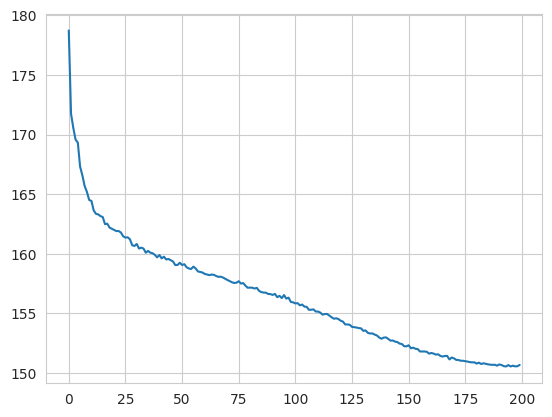

In [77]:
plt.plot(losses)  # 13.24

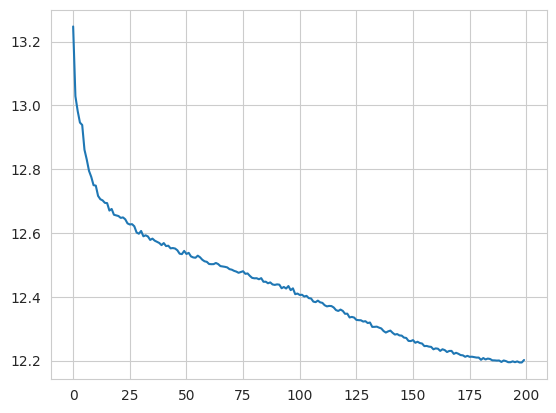

In [78]:
plt.plot(rmses)

### 5.Predict

In [85]:
class TestDataset(Dataset):
    def __init__(self, df):
        self.X = df.values
        self.X = self.X.astype(float)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32)

In [86]:
#df_test = df_test.drop('id')
test_dataset = TestDataset(df_test)
test_dataloader = DataLoader(test_dataset, batch_size=num_batches, shuffle=False)

In [87]:
model.eval()
prediction = []

with torch.no_grad():
    for x_batch in test_dataloader:
        x_batch = x_batch.to(device)
        y_pred = model(x_batch).squeeze().cpu().numpy()
        prediction.extend(y_pred)

In [88]:
submit_df['Listening_Time_minutes'] = prediction
submit_df.head()

,Listening_Time_minutes
id,
750000,57.534306
750001,24.363855
750002,48.761505
750003,82.134079
750004,48.297306


In [91]:
submit_df.to_csv("../output/01_baseline_MLP_Pytorch.csv", index=False)

In [92]:
test_dataset[0]

tensor([34.0000, 78.9600,  2.0000, 38.1100,  5.0000,  2.0000, 53.3300,  1.0000,
         1.0000, 73.0000, 45.4478, 45.4478, 59.6532, 59.9133, 58.3317, 58.1999,
        45.4478, 43.6285, 44.2109, 42.9961, 42.2727, 39.9417, 44.6407, 36.3094,
        47.8249, 47.7420, 47.4873, 46.9562, 45.3183, 44.8381, 44.6965, 45.4478,
        45.4478, 45.4478, 45.4478, 45.4478, 45.4478, 45.4478, 45.4478, 45.4478,
        63.3452, 60.8724, 64.7122, 53.3543, 56.4461, 60.9290, 45.4478, 45.4478,
        45.4478, 45.4478, 45.9857, 44.4187, 42.2137, 45.3596, 44.6521, 42.1538,
        45.0179, 45.4478, 53.4429, 16.3204, 60.5205, 45.4478, 48.1065, 47.3524,
        46.8540, 44.8895, 45.4478, 45.4478, 45.4478, 45.4478, 45.4478, 45.4478,
        45.4478, 45.4478, 45.4478, 45.4478, 45.4478, 45.4478, 45.4478, 45.4478,
        45.4478, 45.4478, 45.4478, 62.7146, 71.8565, 51.0925, 45.4478, 45.4478,
        45.4478, 45.4478, 45.4478, 45.4478, 51.5762, 45.7323, 41.4978, 44.3269,
        45.4478, 52.3273, 45.4478, 45.44